# Modelling with RandomForest Regression:

In this notebook we perform regression with a RandomForest algorithm. The data used is not scaled, nor mean-centered. Since such algorithms yield good results even on non-linear relationship, almost all the initial features are included. We therefore try to reduce the dimensionality of our dataset by comparing 2 methods : Recursive Feature Elimination with cross-validation and Greedy Forward Selection. <br>
We then perform HyperParameters Tuning. Since such agorithm are long to run, we first search randomly across a predefined parameters grid and then confirm the obtained results through GridSearch with Cross Validation. After tuning, we try reproduce the 2 methods of feature selection and compare the results. We end up with the 31 most important features, for which the RMSE is 9.64

In [1]:
## Import packages
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style('darkgrid')

In [2]:
#loading data
train = pd.read_csv('Transformed_Train.csv', index_col="row_id")
labels = pd.read_csv('Predicting_Chronic_Hunger_Training_labels.csv', index_col="row_id")
test = pd.read_csv('Transformed_Test.csv', index_col="row_id")

In [3]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('-------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))

The train data has 1337 rows and 35 columns
-------------------------------------------
The test data has 616 rows and 35 columns


In [4]:
train['undernourishment'] = labels.iloc[train.index]

In [5]:
def copy_values(train_features, train_labels, test_features):
    ## Create features and labels for training/testing models:
    features = train_features.copy().drop('undernourishment', axis=1)
    labels = train_labels.copy()
    labels = labels[labels.index.isin(features.index)]

    ## Create a copy of the features datasets for which we want to predict values
    predict = test_features.copy()
    
    return features, labels, predict

def create_sets(Features, Labels, features_to_use):
    """Creates the X and y sets for training and testing.
    """    
    ## Groupby country code to separate the countries in training and test set
    nr.seed(1234)
    grouped = Features.groupby('country_code')
    indx = range(grouped.ngroups)
    indx = ms.train_test_split(indx, test_size = 0.3, random_state=42)
    
    ## Create index of country_code
    train_index = Features[Features['country_code'].isin([(list(np.array(list(grouped.groups.keys())))[ix]) for ix in indx[0]])].index
    test_index = Features[Features['country_code'].isin([(list(np.array(list(grouped.groups.keys()))))[ix] for ix in indx[1]])].index


    ## Create the train and test sets of features
    X_train = np.array(Features[Features.index.isin(train_index)][features_to_use])
    X_test = np.array(Features[Features.index.isin(test_index)][features_to_use])
    ## Create the train and test sets of labels
    y_train = np.ravel(np.array(Labels[Labels.index.isin(train_index)]))
    y_test = np.ravel(np.array(Labels[Labels.index.isin(test_index)]))
    
    return X_train, y_train, X_test, y_test

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))

In [6]:
to_use = list(test.columns[1:])

In [7]:
# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 98.76022769831394
Root Mean Square Error = 9.937818055202758
Mean Absolute Error    = 7.4881739945817385
Median Absolute Error  = 5.219401542442695
R^2                    = 0.3024650559679828
Adjusted R^2           = 0.29907072534008977


In [8]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

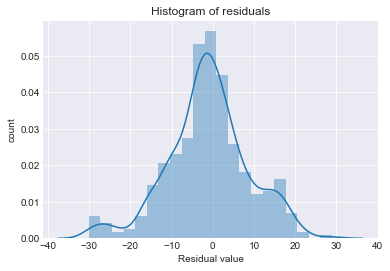

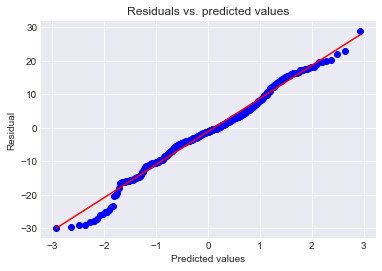

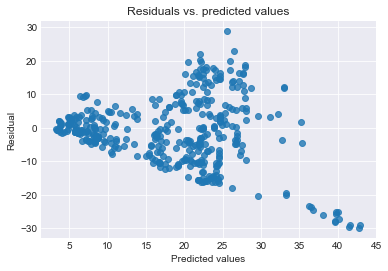

In [9]:
hist_resids(y_test, scores)  
resid_qq(y_test, scores) 
resid_plot(y_test, scores)

Our model perform reasonably well, and our residuals are quite normally distributed. 

# Dimensionality reduction before HyperParameters Tuning

## Feature selection by feature importances:

In [10]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)
RF_FI = RandomForestRegressor()
RF_FI.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
# Get numerical feature importances
importances = list(RF_FI.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(to_use, importances)]

# Sort the feature importances by most important first
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(to_use, importances)]
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
                             
print(importance_df)

                                              Feature  Importance
23                   access_to_improved_water_sources      0.2577
12              gross_domestic_product_per_capita_ppp      0.0944
20             avg_supply_of_protein_of_animal_origin      0.0904
4                                         forest_area      0.0803
25                                 obesity_prevalence      0.0700
31                                political_stability      0.0512
27                              access_to_electricity      0.0415
2   percentage_of_arable_land_equipped_for_irrigation      0.0316
26                                    open_defecation      0.0266
9                        avg_value_of_food_production      0.0259
1                              agricultural_land_area      0.0229
18                                adult_literacy_rate      0.0210
32                             urban_population_share      0.0192
8                                   population_growth      0.0188
11        

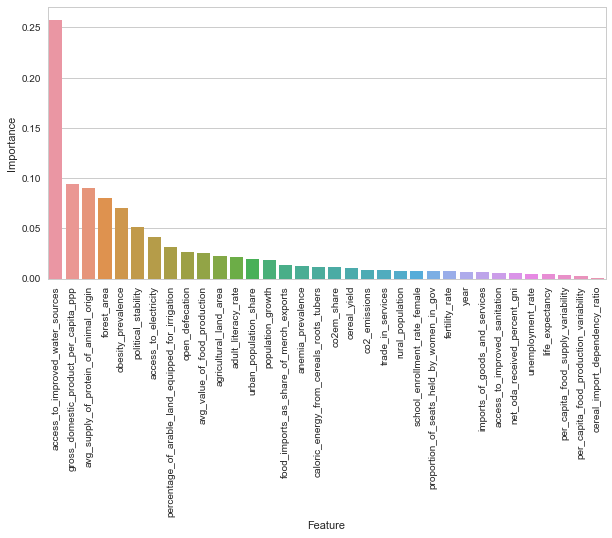

In [12]:
# list of x locations for plotting
x_values = list(range(len(importances)))

plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.barplot(x = 'Feature', y = 'Importance', data=importance_df)
plt.xticks(rotation = 90)
plt.show()

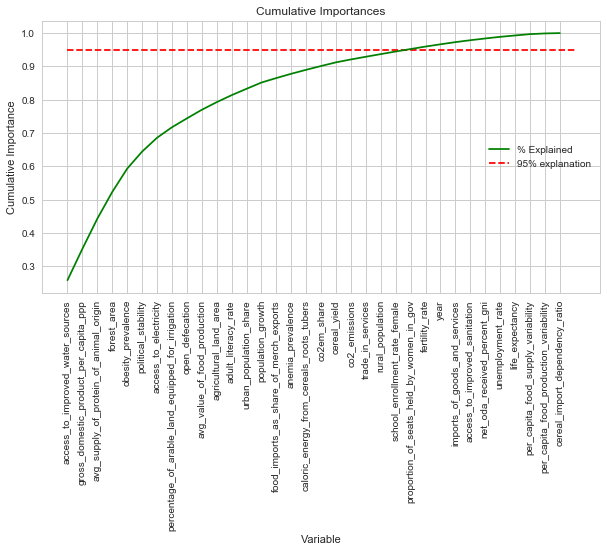

Number of features for 95% importance: 23


In [13]:
# List of features sorted from most to least important
sorted_importances = sorted([importance[1] for importance in feature_importances], reverse=True)
sorted_features = [importance[0] for importance in feature_importances]

# Plot
cumulative_importances = np.cumsum(importance_df['Importance'])
plt.figure(figsize=(10,5))
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed', label='95% explanation')
plt.plot(x_values, cumulative_importances, 'g-', label='% Explained')
plt.xticks(x_values, importance_df['Feature'], rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
plt.legend(loc='center right')
plt.show()

print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0])

In [14]:
# Extract the names of the most important features
important_features = [feature for feature in importance_df['Feature']][0:23]

# Train the model on the important features only
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], important_features)
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
scores = RF.predict(X_test)
print_metrics(y_test, scores, 5)

Mean Square Error      = 88.85355170798911
Root Mean Square Error = 9.426216192512726
Mean Absolute Error    = 6.918375297460438
Median Absolute Error  = 4.934870756444883
R^2                    = 0.37243505141557876
Adjusted R^2           = 0.3662974969061957


60% of the features explains 95% of our model predictions and our metrics seems to improve without the less explanatory 15 features.

## Recursive Feature Elimination

In [15]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)

estimator = RandomForestRegressor()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

array([ 4,  1,  1,  1,  1,  1,  6,  1,  1,  1,  9,  1,  3,  5,  2,  1,  8,
        7, 10, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [16]:
## Features selected with RFE
indexes = [i for i, x in enumerate(selector.ranking_) if x == 1 ]
RFECV_features = list(np.array(to_use)[indexes])
RFECV_features

['agricultural_land_area',
 'percentage_of_arable_land_equipped_for_irrigation',
 'cereal_yield',
 'forest_area',
 'fertility_rate',
 'rural_population',
 'population_growth',
 'avg_value_of_food_production',
 'food_imports_as_share_of_merch_exports',
 'trade_in_services',
 'avg_supply_of_protein_of_animal_origin',
 'caloric_energy_from_cereals_roots_tubers',
 'access_to_improved_sanitation',
 'access_to_improved_water_sources',
 'anemia_prevalence',
 'obesity_prevalence',
 'open_defecation',
 'access_to_electricity',
 'co2_emissions',
 'unemployment_rate',
 'proportion_of_seats_held_by_women_in_gov',
 'political_stability',
 'urban_population_share',
 'co2em_share']

In [17]:
# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], RFECV_features)

RF_RFE = RandomForestRegressor()
RF_RFE.fit(X_train, y_train)

scores = RF_RFE.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 90.45671245500684
Root Mean Square Error = 9.510873380242575
Mean Absolute Error    = 7.132635517409717
Median Absolute Error  = 5.473388683594713
R^2                    = 0.3611120657561965
Adjusted R^2           = 0.35800312203724854


Recursive Feature Elimination with cross-validation performs less well than by importances. We end up with 25 features out of 37, compared to 21 with the forward selection method. Considering RandomForest algorithm is time-consuming and greedy in terms of processing ressources, reducing the number of features by 40% will facilitate the HyperParameters Tuning.

## Tuning Hyper Parameters

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']          # Number of features to consider at every split

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]           # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]             # Minimum number of samples required at each leaf node
bootstrap = [True, False]                # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid) # 4320 settings

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [19]:
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], important_features)

RF_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [20]:
RF_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [21]:
params = {'n_estimators': [300, 400, 500], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 5]} 

RF_GS = RandomForestRegressor(max_features='sqrt', max_depth=None, bootstrap=False)
grid_search = GridSearchCV(estimator = RF_GS, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.7s finished


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

The GridSearch with cross-validation confirms that the parameter grid we now have is optimal. 

In [22]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], RFECV_features)

# Test with the best parametrs found with Random Grid Search
RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)
scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 76.59678270892255
Root Mean Square Error = 8.751958792688786
Mean Absolute Error    = 6.55351046349594
Median Absolute Error  = 5.217979021598033
R^2                    = 0.4590035504665708
Adjusted R^2           = 0.4563709643374544


In [23]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], important_features)

# Test with the best parametrs found with Random Grid Search
RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)
scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 74.8652515710242
Root Mean Square Error = 8.652470836184552
Mean Absolute Error    = 6.423573328537574
Median Absolute Error  = 4.582472843025434
R^2                    = 0.47123320509083044
Adjusted R^2           = 0.46866013066304857


In [24]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)

# Test with the best parametrs found with Random Grid Search
RF = RandomForestRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)
scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 74.7793720788384
Root Mean Square Error = 8.647506697241605
Mean Absolute Error    = 6.472727486943507
Median Absolute Error  = 5.012753415820338
R^2                    = 0.4718397645143092
Adjusted R^2           = 0.46926964171389224


We notice that although we selected less features before proceeding to hyperparameters tuning in order to reduce the time of this operation, conserving all features yields better results. The difference is however quite small with the important features. 

# Final Feature Selection
## Recursive Feature Elimination

In [25]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use) #important_feature_names

In [26]:
estimator = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
selector = RFECV(estimator, cv=5, scoring='neg_mean_squared_error')
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

array([8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 7, 1, 4, 6, 9, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1])

In [27]:
## Features selected with RFE
indexes = [i for i, x in enumerate(selector.ranking_) if x <= 1 ]
RFECV_features = list(np.array(to_use)[indexes])
len(RFECV_features)

26

In [28]:
# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], RFECV_features)

RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)

scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 76.98743254024753
Root Mean Square Error = 8.774248260691484
Mean Absolute Error    = 6.5625469207664375
Median Absolute Error  = 4.882494459766804
R^2                    = 0.4562444245048347
Adjusted R^2           = 0.4535984119720115


Recursive Feature Elimination with cross-validation indeed yields slightly better results, and reduces our dataset to 27 features, which should improve interpretability and generalization. 

## Importance features

We select the optimal number of features by sorting all 37 by importances, and then runing our algorithm

In [29]:
# Get numerical feature importances
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)

RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)

importances = list(RF.feature_importances_)

# List of tuples then DF with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(to_use, importances)]
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Cumulative importances of features
cumulative_importances = np.cumsum(importance_df['Importance'])
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0])

Number of features for 95% importance: 28


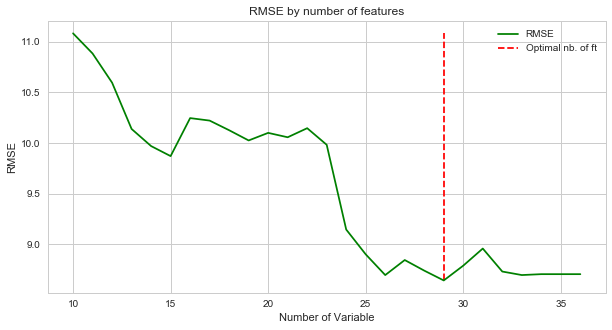

In [30]:
# Create range and list to store RMSE:
x = range(10,37)
y = []

# Iterate with different number of features
for i in range(10,37):
    important_features = [feature[0] for feature in feature_importances[0:i]]
    X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], important_features)
    RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
    RF.fit(X_train, y_train)
    scores = RF.predict(X_test)
    y.append(math.sqrt(sklm.mean_squared_error(y_test, scores)))

# Plot the RMSE by number of results
plt.figure(figsize=(10,5))
plt.plot(x, y, 'g-', label = 'RMSE')
plt.vlines(x = x[y.index(min(y))], ymin = min(y), ymax=max(y), color = 'r', linestyles = 'dashed', label='Optimal nb. of ft')
plt.legend()
plt.xlabel('Number of Variable'); plt.ylabel('RMSE'); plt.title('RMSE by number of features')
plt.show()

In [34]:
# Select the 23 most important features:
important_features = [feature[0] for feature in feature_importances[0:29]]

# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], important_features)

# Train the models with tuned parameters
RF = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
RF.fit(X_train, y_train)

# Evaluate predictions
scores = RF.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 74.71921792910516
Root Mean Square Error = 8.644027876465065
Mean Absolute Error    = 6.534370551178473
Median Absolute Error  = 5.008429420990664
R^2                    = 0.4722646280696632
Adjusted R^2           = 0.46969657273180265


We will therefore use the greedy forward feature selection method to keep the 29 most important features.